# Imports

In [13]:
import pandas as pd
from pathlib import Path
import os
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import seaborn

# Obtenção dos dados

In [14]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)


# PCR

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
def simple_regression(X,y):
 
    # Create linear regression object
    regr = linear_model.LinearRegression()
 
    # Fit
    regr.fit(X, y)
 
    # Calibration
    y_c = regr.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(regr, X, y, cv=10)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    return(y_cv, score_c, score_cv, mse_c, mse_cv)

def pcr(X,y, pc):
 
    ''' Step 1: PCA on input data'''
 
    # Define the PCA object
    pca = PCA()
 
    # Preprocess (2) Standardize features by removing the mean and scaling to unit variance
    Xstd = StandardScaler().fit_transform(X)
 
    # Run PCA producing the reduced variable Xreg and select the first pc components
    Xpca = pca.fit_transform(Xstd)
 
    # Define a correlation array
    corr = np.zeros(Xpca.shape[1])
    # Calculate the absolute value of the correlation coefficients for each PC
    for i in range(Xpca.shape[1]):
        corr[i] = np.abs(np.corrcoef(Xpca[:,i], y)[0, 1])
 
    # Sort the array based on the corr values and select the last pc values 
    Xreg = (Xpca[:,np.argsort(corr)])[:,-pc:]
 
    ''' Step 2: regression on selected principal components'''
    y_cv, score_c, score_cv, mse_c, mse_cv = simple_regression(Xreg, y)
    
    bias_cv = np.mean(y - y_cv)
 
    return(y_cv, score_c, score_cv, mse_c, mse_cv, bias_cv)


In [50]:

X = df_msc.values[:,7:]
y = df_raw['SST'].values
 
npc = 40 # maximum number of principal components
pc = range(1,npc+1,1)
# Define arrays for R^2 and MSE
r2c = np.zeros(npc)
r2cv = np.zeros(npc)
msec = np.zeros(npc)
msecv = np.zeros(npc)
bias_cv = np.zeros(npc)

best_pc = 0
best_score_cv = -np.inf  # Initialize with a very low value
 
for i in pc:
    predicted, r2c[i-1], r2cv[i-1], msec[i-1], msecv[i-1], bias_cv[i-1] = pcr(X,y, pc=i)
    # Check if current score_cv is better than the best so far
    if r2cv[i - 1] > best_score_cv:
        best_score_cv = r2cv[i - 1]
        best_pc = i
        
print(f"Best number of principal components chosen: {best_pc}")
print(f"Corresponding R2 CV: {best_score_cv}")

Best number of principal components chosen: 40
Corresponding R2 CV: 0.8557106111439763


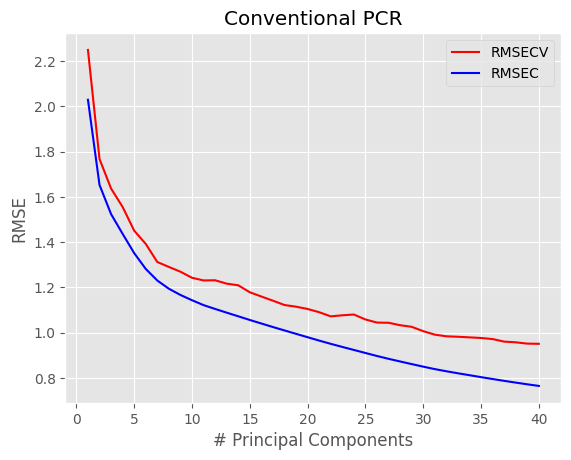

In [51]:
with plt.style.context(('ggplot')):
    plt.plot(pc, np.sqrt(msecv[:]), 'r', label = "RMSECV")
    plt.plot(pc, np.sqrt(msec[:]), 'b', label = "RMSEC")
    plt.xlabel("# Principal Components")
    plt.ylabel("RMSE")
    plt.title("Conventional PCR")
    plt.legend()
    plt.show()

R² REF: 0.8935572127824191
R² CV: 0.7626388857136409
RMSE REF: 7.81126554371994
RMSE CV: 11.664552144309239
RPD: 0.21463385253312534
Bias CV: 0.034952891811102546


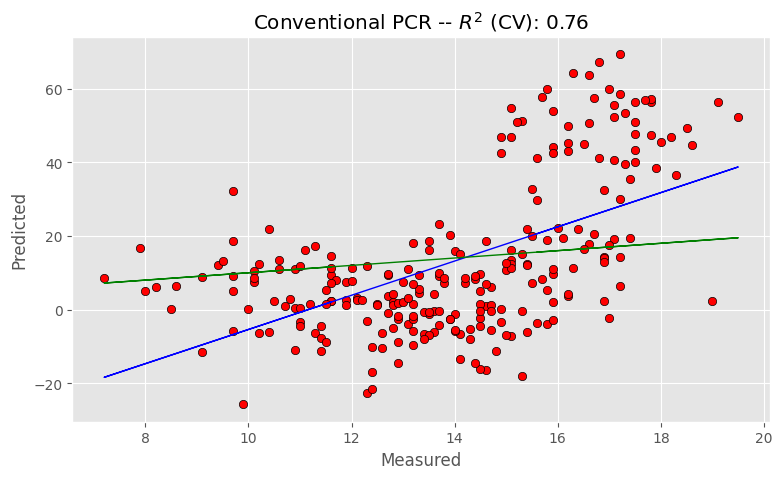

In [58]:
predicted, r2r, r2cv, mser, mscv, bias_cv = pcr(X,df_raw['AT'], pc=40)

print("R² REF: " + str(r2r))
print("R² CV: " + str(r2cv))
print("RMSE REF: " + str(np.sqrt(mser)))
print("RMSE CV: " + str(np.sqrt(mscv)))
print("RPD: " + str(np.std(y) / np.sqrt(mscv)))
print("Bias CV: " + str(bias_cv))

# Regression plot
z = np.polyfit(y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y, predicted, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)
    plt.title('Conventional PCR -- $R^2$ (CV): {0:.2f}'.format(r2cv))
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.show()

R² REF: 0.9066584575693926
R² CV: 0.8557106111439763
RMSE REF: 0.7648984421350375
RMSE CV: 0.9510065032960998
RPD: 2.63258742829765
Bias CV: -0.017900731215061597


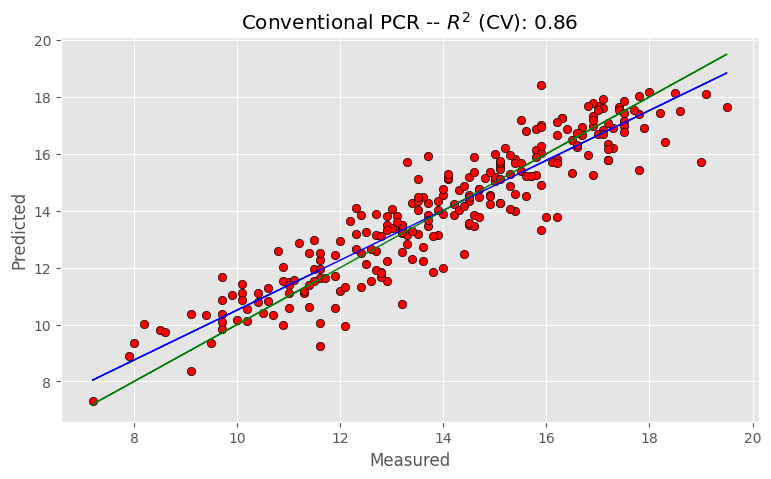

In [57]:
predicted, r2r, r2cv, mser, mscv, bias_cv = pcr(X,y, pc=40)

print("R² REF: " + str(r2r))
print("R² CV: " + str(r2cv))
print("RMSE REF: " + str(np.sqrt(mser)))
print("RMSE CV: " + str(np.sqrt(mscv)))
print("RPD: " + str(np.std(y) / np.sqrt(mscv)))
print("Bias CV: " + str(bias_cv))

# Regression plot
z = np.polyfit(y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y, predicted, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)
    plt.title('Conventional PCR -- $R^2$ (CV): {0:.2f}'.format(r2cv))
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.show()

R² REF: 0.8011309141257485
R² CV: 0.6494441343439538
RMSE REF: 0.11950970877255246
RMSE CV: 0.15867122275481274
RPD: 15.778587454861482
Bias CV: 0.00305162436099298


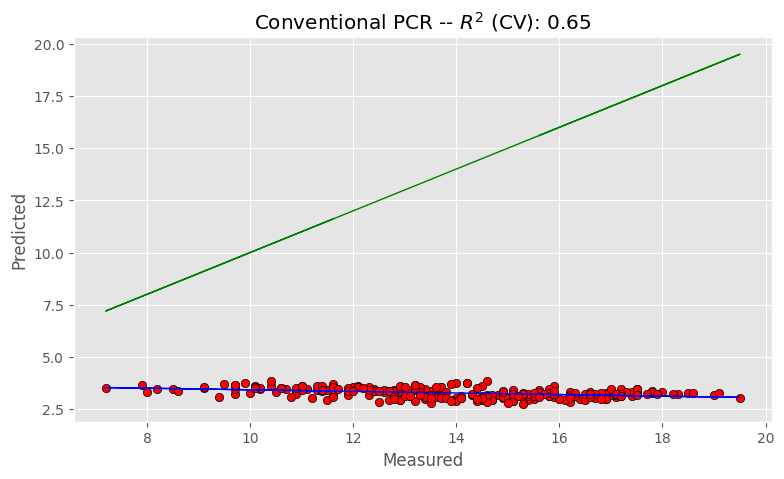

In [59]:

predicted, r2r, r2cv, mser, mscv, bias_cv = pcr(X,df_raw['PH'], pc=40)

print("R² REF: " + str(r2r))
print("R² CV: " + str(r2cv))
print("RMSE REF: " + str(np.sqrt(mser)))
print("RMSE CV: " + str(np.sqrt(mscv)))
print("RPD: " + str(np.std(y) / np.sqrt(mscv)))
print("Bias CV: " + str(bias_cv))

# Regression plot
z = np.polyfit(y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y, predicted, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)
    plt.title('Conventional PCR -- $R^2$ (CV): {0:.2f}'.format(r2cv))
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.show()

R² REF: 0.7900560080838531
R² CV: 0.6619508601131338
RMSE REF: 43.9683760107464
RMSE CV: 55.79285910045183
RPD: 0.04487326523810186
Bias CV: 1.9469801513666372


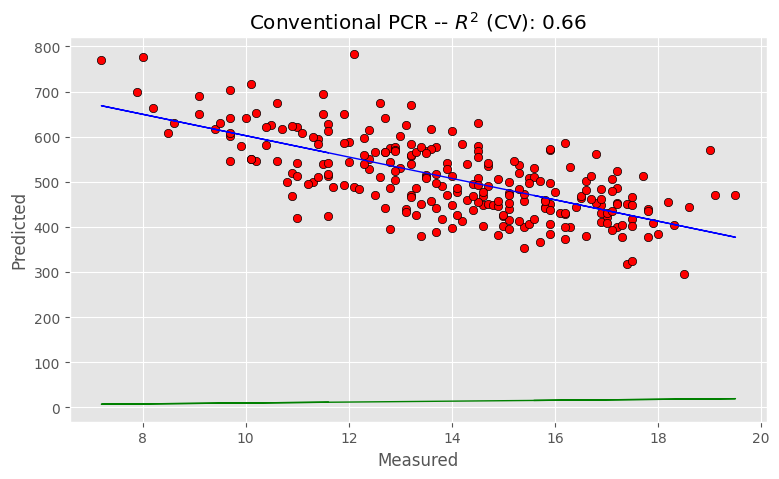

In [60]:

predicted, r2r, r2cv, mser, mscv, bias_cv = pcr(X,df_raw['FIRMEZA (N)'], pc=40)

print("R² REF: " + str(r2r))
print("R² CV: " + str(r2cv))
print("RMSE REF: " + str(np.sqrt(mser)))
print("RMSE CV: " + str(np.sqrt(mscv)))
print("RPD: " + str(np.std(y) / np.sqrt(mscv)))
print("Bias CV: " + str(bias_cv))

# Regression plot
z = np.polyfit(y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y, predicted, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)
    plt.title('Conventional PCR -- $R^2$ (CV): {0:.2f}'.format(r2cv))
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.show()

R² REF: 0.8751085623965853
R² CV: 0.7807212742336488
RMSE REF: 1.0397660676101768
RMSE CV: 1.3777409195437953
RPD: 1.8171832811902164
Bias CV: 0.005942844456023348


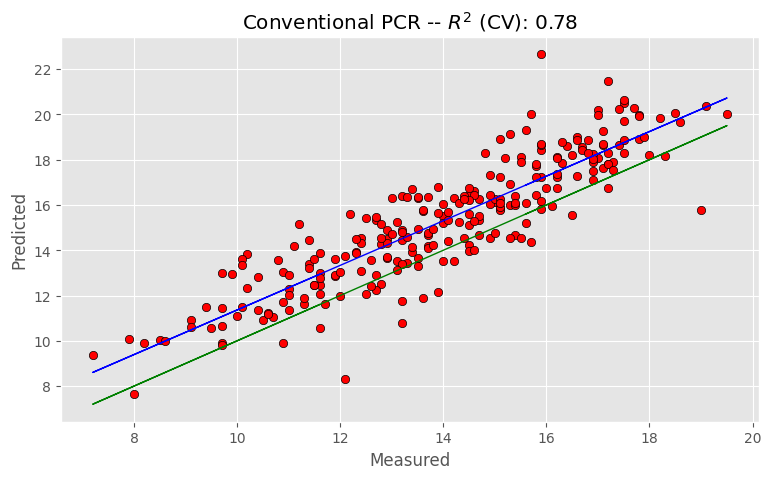

In [61]:

predicted, r2r, r2cv, mser, mscv, bias_cv = pcr(X,df_raw['UBS (%)'], pc=40)

print("R² REF: " + str(r2r))
print("R² CV: " + str(r2cv))
print("RMSE REF: " + str(np.sqrt(mser)))
print("RMSE CV: " + str(np.sqrt(mscv)))
print("RPD: " + str(np.std(y) / np.sqrt(mscv)))
print("Bias CV: " + str(bias_cv))

# Regression plot
z = np.polyfit(y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(y, predicted, c='red', edgecolors='k')
    ax.plot(y, z[1]+z[0]*y, c='blue', linewidth=1)
    ax.plot(y, y, color='green', linewidth=1)
    plt.title('Conventional PCR -- $R^2$ (CV): {0:.2f}'.format(r2cv))
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.show()